# All Saxophones, Brass OK: SVM

* model = SVM
* features = MFCC
* target = ALL SAXES

Use SVM model to classify whether or not a saxophone is playing in a sample, samples including brass instruments are left in the dataset.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import AUC, Recall
from sklearn.model_selection import train_test_split, RandomizedSearchCV, \
    GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_curve, \
    roc_curve, roc_auc_score, confusion_matrix, \
    classification_report
from scipy.stats import uniform

from _common import NUM_LABEL_COLS, RANDOM_SEED
from _all_saxes_brass_ok_mfcc import TEST_SIZE, VALIDATION_SIZE, \
    BANDS, TIME_SLICES, data, target

In [3]:
NUM_COMPONENTS = 28

In [4]:
pca = PCA(n_components=NUM_COMPONENTS)    # optimal n_components value determined in mt_cc_all_saxes_brass_ok_pca_lmsc

In [5]:
pca.fit(data)

PCA(n_components=28)

In [5]:
# print(pca.explained_variance_ratio_)

In [6]:
# print(pca.singular_values_)

In [6]:
d = pca.transform(data)

In [8]:
# d

In [7]:
x_train, x_test, y_train, y_test = \
     train_test_split(d, target,
                      test_size=TEST_SIZE,
                      random_state=RANDOM_SEED)

## Test plain vanilla SVM

In [8]:
clf = SVC()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print(clf.score(x_test, y_test))

0.8161888701517707


In [9]:
c_matrix = confusion_matrix(y_test, y_pred)
idx = cols = [0, 1]
pd.DataFrame(c_matrix, index=idx, columns=cols)

,0,1
0,562,194
1,133,890


In [10]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.74      0.77       756
           1       0.82      0.87      0.84      1023

    accuracy                           0.82      1779
   macro avg       0.81      0.81      0.81      1779
weighted avg       0.82      0.82      0.81      1779



## Determine good value for C using random search

In [13]:
# model_params = {
#     'C': uniform(0.1, 3.0)
# }

# svm_model = SVC()
# clf = RandomizedSearchCV(svm_model, model_params, n_iter=10, 
#                          cv=5)
# model = clf.fit(x_train, y_train)
# params = model.best_estimator_.get_params()
# print(params)

# C = 3.025

{'C': 3.024513162400543, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [11]:
clf = SVC(C=3.024513162400543)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print(clf.score(x_test, y_test))


0.8240584598088814


In [12]:
c_matrix = confusion_matrix(y_test, y_pred)
idx = cols = [0, 1]
pd.DataFrame(c_matrix, index=idx, columns=cols)

,0,1
0,577,179
1,134,889


In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.76      0.79       756
           1       0.83      0.87      0.85      1023

    accuracy                           0.82      1779
   macro avg       0.82      0.82      0.82      1779
weighted avg       0.82      0.82      0.82      1779



## Test ensemble approach with bagging classifier

In [17]:
# param_grid = {'max_features': [NUM_COMPONENTS - 2, NUM_COMPONENTS - 3, 
#                                NUM_COMPONENTS - 4, NUM_COMPONENTS - 5,
#                                NUM_COMPONENTS - 6, NUM_COMPONENTS - 7, 
#                                NUM_COMPONENTS - 8, NUM_COMPONENTS - 9,
#                                NUM_COMPONENTS - 10, NUM_COMPONENTS - 11,
#                                NUM_COMPONENTS - 12, NUM_COMPONENTS - 13]}

# base_estimator = SVC(C=params['C'])
# estimator = BaggingClassifier(base_estimator=base_estimator, n_estimators=100)

# clf = GridSearchCV(estimator, param_grid, n_jobs=-1)
# search = clf.fit(x_train, y_train)
# search.best_params_

# max_features = 17

In [14]:
clf = BaggingClassifier(base_estimator=SVC(C=3.024513162400543),
                        n_estimators=500, 
                        max_features=17,
                        random_state=42)
model = clf.fit(x_train, y_train)

In [15]:
y_pred = clf.predict(x_test)
print(clf.score(x_test, y_test))

0.818999437886453


In [16]:
c_matrix = confusion_matrix(y_test, y_pred)
idx = cols = [0, 1]
pd.DataFrame(c_matrix, index=idx, columns=cols)

,0,1
0,552,204
1,118,905


In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.73      0.77       756
           1       0.82      0.88      0.85      1023

    accuracy                           0.82      1779
   macro avg       0.82      0.81      0.81      1779
weighted avg       0.82      0.82      0.82      1779



In [18]:
probas_pred = model.predict_proba(x_test)

In [19]:
y_pred_pos = probas_pred[:, [1]]

In [24]:
y_true = [1 if x == 1 else 0 for x in y_test]

In [25]:
precision, recall, threshold = precision_recall_curve(y_true, y_pred_pos)

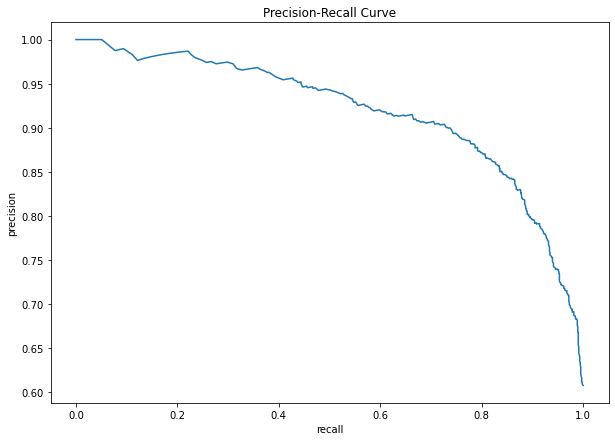

In [26]:
fig = plt.figure(figsize=(10, 7))    
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title("Precision-Recall Curve")
pass

In [27]:
fpr, tpr, threshold = roc_curve(y_true, y_pred_pos)
auc = roc_auc_score(y_true, y_pred_pos)

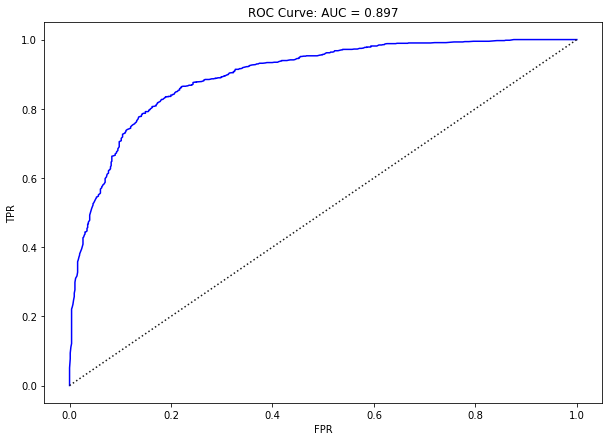

In [28]:
fig = plt.figure(figsize=(10, 7))    
plt.plot(fpr, tpr, 'b')
plt.plot([0, 1], [0, 1], ':', color='0.1')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("ROC Curve: AUC = {:.3f}".format(auc)) 
pass